### Splitting the Dataset 

In [16]:
# import splitfolders 


# input_folder = 'D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet'


# splitfolders.ratio(input_folder, output='D:\IIT\Subjects\(4605)IRP\Devlo\Augmented_DataSet_Split', seed=42, ratio=(.7, .2, .1), group_prefix=None) 

### Importing required libraries

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import glob
import cv2
import seaborn as sns
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16

In [18]:
TRAIN_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/train"
VAL_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/val"
TEST_PATH = "D:/IIT/Subjects/(4605)IRP/Devlo/Augmented_DataSet_Split/test"

### Initializing Image Size

In [19]:
IMAGE_SIZE = (128, 128)

### Initializing train, validation & test data

In [20]:
import tensorflow as tf

# Load datasets
training_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_PATH,
    validation_split=None,
    subset=None,
    shuffle=True,
    batch_size=32,
    image_size=IMAGE_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    validation_split=None,
    subset=None,
    shuffle=False,
    batch_size=32,
    image_size=IMAGE_SIZE
)


Found 6698 files belonging to 4 classes.
Found 1914 files belonging to 4 classes.
Found 958 files belonging to 4 classes.


### Plot Images with labels

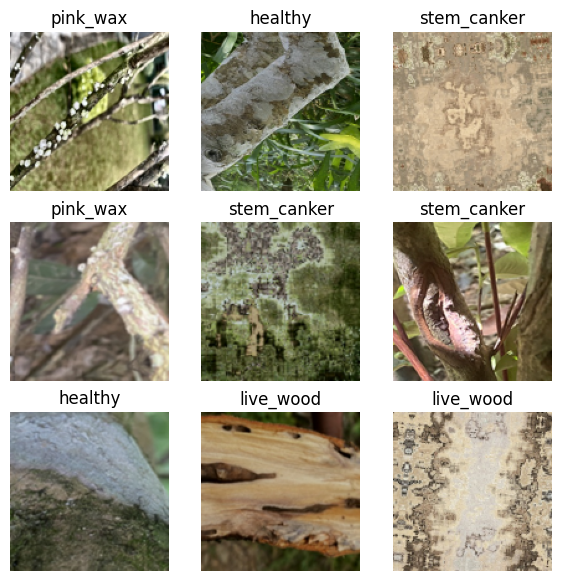

In [21]:
plt.figure(figsize=(7, 7))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(training_ds.class_names[labels[i]])
        plt.axis("off")

In [22]:
class_num = 4
input_shape = (128,128,3)

### Import model for Transfer Learning

In [23]:
vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling="avg",
    classes=class_num
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 41s 1us/step


In [24]:
vgg16.summary() 

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Freeze layerns in EfficientNetB1

In [25]:
for layer in vgg16.layers[:-5]:
    layer.trainable = False

In [26]:
for layer in vgg16.layers:
    print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True


### Building the classification model

In [27]:
inputs = tf.keras.Input(shape=input_shape, name='image_input')

x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = vgg16(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(.3)(x)
outputs = Dense(class_num, activation='softmax')(x)

effnet_model = tf.keras.Model(inputs, outputs, name='output')

### Compile the model

In [28]:
effnet_model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(effnet_model, to_file='model_eff.png',show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### Train the model

In [30]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
#mc =  ModelCheckpoint('VGG16_classification.h5', monitor='val_loss', verbose=1, save_best_only=True)
mc = ModelCheckpoint('D:\IIT\Subjects\(4605)IRP\Devlo\models\VGG16_classification.keras', monitor='val_loss', verbose=1, save_best_only=True)


history_effnet = effnet_model.fit(training_ds, validation_data = val_ds,
          epochs = 30, batch_size = 32, callbacks = [es, mc])


Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2535 - loss: 6.6312
Epoch 1: val_loss improved from inf to 3.40142, saving model to D:\IIT\Subjects\(4605)IRP\Devlo\models\VGG16_classification.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.2535 - loss: 6.6236 - val_accuracy: 0.2612 - val_loss: 3.4014
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2590 - loss: 3.0723
Epoch 2: val_loss improved from 3.40142 to 2.34945, saving model to D:\IIT\Subjects\(4605)IRP\Devlo\models\VGG16_classification.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.2590 - loss: 3.0710 - val_accuracy: 0.2612 - val_loss: 2.3494
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2567 - loss: 2.2086
Epoch 3: val_loss improved from 2.34945 to 1.88135, saving model to D:\IIT\Subjects\(4605)IRP\Devlo\models\VGG16_classification.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.2567 - loss: 2.2080 - val_accuracy: 0.2612 - val_loss: 

KeyboardInterrupt: 

### Train, Validation & Test accuracy from saved model

In [ ]:
from keras.models import load_model
saved_model = load_model('D:\IIT\Subjects\(4605)IRP\Devlo\models\VGG16_classification.keras')

train_loss, train_acc = saved_model.evaluate(training_ds, verbose=0)
val_loss, val_acc = saved_model.evaluate(val_ds, verbose=0)
test_loss, test_acc = saved_model.evaluate(test_ds, verbose=0)


print(f'Accuracy and loss of the best model : ')
print(f'Train accuracy: {train_acc*100:.3f} % || Validation accuracy: {val_acc*100:.3f} % || Test accuracy: {test_acc*100:.3f} %')
print(f'Train loss: {train_loss:.3f} || Validation loss: {val_loss:.3f} || Test loss: {test_loss:.3f}')

### Plot Accuracy & Loss graphs

In [ ]:
fig1 = plt.gcf()
plt.plot(history_effnet.history['accuracy'])
plt.plot(history_effnet.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history_effnet.history['loss'])
plt.plot(history_effnet.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predictions on Test data

In [ ]:
prediction_effnet = saved_model.predict(test_ds) 
prediction_effnet=np.argmax(prediction_effnet,axis=1)

In [ ]:
true_labels = []  

for image_batch, label_batch in test_ds:
    true_labels.append(label_batch)
    
correct_labels = tf.concat([item for item in true_labels], axis = 0)
correct_labels = correct_labels.numpy()

In [ ]:
print(type(prediction_effnet))
print(type(correct_labels))

### F1- Score, Precision & Recall

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(correct_labels, prediction_effnet))

### Confusion Matrix

In [ ]:
cm = confusion_matrix(correct_labels, prediction_effnet)

fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)